In [ ]:
# install required system dependencies
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install x11-utils > /dev/null 2>&1
!pip install pyglet==v1.5.0

In [ ]:
import math
import time
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from collections import namedtuple
from itertools import count
from PIL import Image
import cv2

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# Open AI related
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only

import glob
import io
import base64
from IPython.display import HTML

# set up OpenAi Gym render in Colab
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
_display = Display(visible=False,  # use False with Xvfb
                   size=(1400, 900))
_ = _display.start()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Show Gym Environment

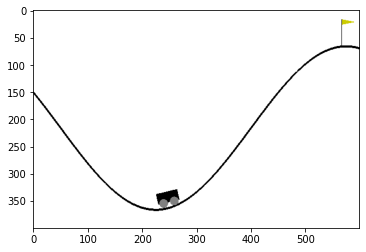

In [ ]:
env = gym.make('MountainCar-v0').unwrapped
env.reset()
img = plt.imshow(env.render(mode='rgb_array')) # returned screen by gym is 400x600x3

## Parameters

In [ ]:
BATCH_SIZE = 32
GAMMA = 0.999
EPS_START = 1 # explore rate (start)
EPS_END = 0.1 # explore rate (end)
MAX_EPS_DECAY_STEPS = 500000
TARGET_UPDATE = 10 # Freqency of updating target network, copying all weights and biases in DQN
REPLAY_MEMORY_SIZE = 50000
NUM_EPISODE = 150
k = 4 # Agenet select new action on every kth frame
SCREEN_SIZE = 84 # height and width since we want training image to be a square

## Replay Memory

In [ ]:
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## Deep Q Network

In [ ]:
class DQN(nn.Module):

    def __init__(self, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(4, 16, kernel_size=8, stride=4) 
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size, stride):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        
        conv_size1 = conv2d_size_out(SCREEN_SIZE, 8, 4)
        conv_size2 = conv2d_size_out(conv_size1, 4, 2)
        conv_size3 = conv2d_size_out(conv_size2, 3, 1)

        linear_input_size = conv_size3 * conv_size3 * 32
        print("linear_input_size:", linear_input_size)

        # fully connected layor
        self.fc1 = nn.Linear(linear_input_size, 256)
        self.fc2 = nn.Linear(256, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)

        # fully connected
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Extract and Process Images from Gym Environment

In [ ]:
def get_screen(environment):
    # Transpose returned screen from gym (400x600x3) into torch order (CHW).
    screen = environment.render(mode='rgb_array').transpose((2, 0, 1))
    
    # Convert to float, rescale, convert to torch tensor
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize
    resize = T.Compose([T.ToPILImage(),
                    T.Grayscale(num_output_channels=1),
                    T.Resize((SCREEN_SIZE, SCREEN_SIZE), interpolation=Image.CUBIC),
                    T.ToTensor()])
    return resize(screen)

def stack_past_four_frames(frame1, frame2, frame3, frame4):
    frames = torch.stack([frame1.squeeze(0), frame2.squeeze(0), frame3.squeeze(0), frame4.squeeze(0)], dim=0)
    # Add a batch dimension (BCHW)
    return frames.unsqueeze(0).to(device)


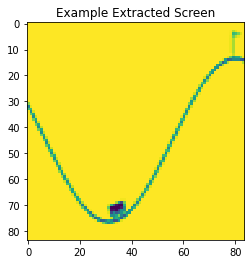

In [ ]:
env.reset()
plt.figure()
example_screen = get_screen(env).cpu().squeeze(0).numpy()
plt.imshow(example_screen, interpolation='none')
plt.title('Example Extracted Screen')
plt.show()

## Training

In [ ]:
# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(n_actions).to(device)
target_net = DQN(n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(REPLAY_MEMORY_SIZE)

steps_done = 0

linear_input_size: 1568
linear_input_size: 1568


In [ ]:
def decay_epsilon(step):
    # linearly decay epsilon
    frac = min(float(step) / MAX_EPS_DECAY_STEPS, 1.0)
    return EPS_START + frac*(EPS_END - EPS_START)

def get_q_values(state):
    return policy_net(state)

def select_action(q_values):
    global steps_done
    sample = random.random()
    eps_threshold = decay_epsilon(steps_done)
    steps_done += 1
    if sample > eps_threshold:
        # t.max(1) will return largest column value of each row.
        # second column on max result is index of where max element was
        # found, so we pick action with the larger expected reward.
        return q_values.max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [ ]:
episode_durations = []
all_episode_max_q_vals = []
all_episode_training_time = []

def train(num_episode, environment):
    for i_episode in range(num_episode):
        # Initialize the environment and state
        environment.reset()
        # Stack 4 most recent frames
        past_screen3 = get_screen(environment)
        past_screen2 = get_screen(environment)
        past_screen1 = get_screen(environment)
        current_screen = get_screen(environment)
        state = stack_past_four_frames(current_screen, past_screen1, past_screen2, past_screen3)

        max_q_vals = []
        last_action = None
        start = time.time()
        for t in count():
            print("episode {}, iteration {}".format(i_episode, t))
            
            # Select and perform an action on every kth frame
            if t % k == 0:
                # Compute Q values from policy net
                q_values = get_q_values(state)
                print("q values: ", q_values)
                max_q_vals.append(q_values.max().item())

                # Choose action based on max q value
                action = select_action(q_values)
                last_action = action
            else:
                action = last_action
            print("Action: ", action.item())

            # Execute action
            new_ob, reward, done, info = environment.step(action.item())

            # re-evaluate reward
            if new_ob[0] > 0.1:
              reward = 1
            elif new_ob[0] > 0.25:
              reward = 2
            reward = torch.tensor([reward], device=device)

            # Observe new state
            past_screen3 = past_screen2
            past_screen2 = past_screen1
            past_screen1 = current_screen
            current_screen = get_screen(environment)
            print("Current state after Action: ", new_ob)
            
            if not done:
                next_state = stack_past_four_frames(current_screen, past_screen1, past_screen2, past_screen3)
            else:
                next_state = None

            # Store the transition in memory
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the target network)
            optimize_model()
            if done:
                end = time.time()
                all_episode_training_time.append(end - start)
                episode_durations.append(t + 1)
                all_episode_max_q_vals.append(max_q_vals)
                break
        # Update the target network, copying all weights and biases in DQN
        if i_episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

    print('Training Complete')

In [ ]:
train(NUM_EPISODE, env)
env.close()

Streaming output truncated to the last 5000 lines.
episode 148, iteration 469
Action:  2
Current state after Action:  [-0.47451829 -0.02894281]
episode 148, iteration 470
Action:  2
Current state after Action:  [-0.50282788 -0.02830959]
episode 148, iteration 471
Action:  2
Current state after Action:  [-0.53029315 -0.02746527]
episode 148, iteration 472
q values:  tensor([[4.9860, 4.9692, 4.9642]], device='cuda:0', grad_fn=<AddmmBackward>)
Action:  0
Current state after Action:  [-0.55870821 -0.02841506]
episode 148, iteration 473
Action:  0
Current state after Action:  [-0.58786044 -0.02915223]
episode 148, iteration 474
Action:  0
Current state after Action:  [-0.61753369 -0.02967325]
episode 148, iteration 475
Action:  0
Current state after Action:  [-0.64751171 -0.02997802]
episode 148, iteration 476
q values:  tensor([[5.0113, 4.9842, 5.0598]], device='cuda:0', grad_fn=<AddmmBackward>)
Action:  2
Current state after Action:  [-0.67558164 -0.02806993]
episode 148, iteration 477
Ac

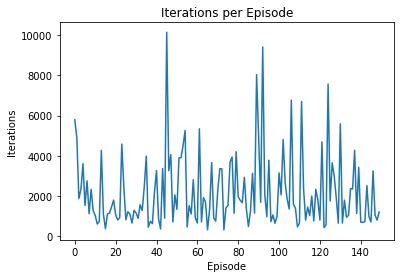

In [ ]:
plt.title('Iterations per Episode')
plt.xlabel('Episode')
plt.ylabel('Iterations')
plt.plot(episode_durations)

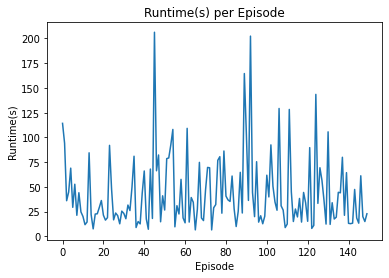

In [ ]:
plt.title('Runtime(s) per Episode')
plt.xlabel('Episode')
plt.ylabel('Runtime(s)')
plt.plot(all_episode_training_time)

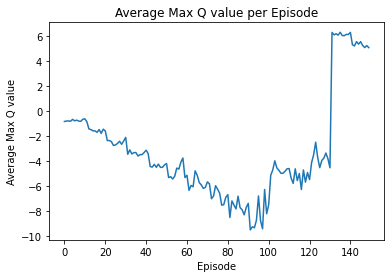

In [ ]:
# calculate average max q value per episode
avg_max_qVals = []
for vals in all_episode_max_q_vals:
    avg_max_qVal = sum(vals)/len(vals)
    avg_max_qVals.append(avg_max_qVal)
plt.title('Average Max Q value per Episode')
plt.xlabel('Episode')
plt.ylabel('Average Max Q value')
plt.plot(avg_max_qVals)

## Test

In [ ]:
# Initialize the environment and state
test_env = gym.make('MountainCar-v0').unwrapped
test_env.reset()

# Stack 4 most recent frames
past_screen3 = get_screen(test_env)
past_screen2 = get_screen(test_env)
past_screen1 = get_screen(test_env)
current_screen = get_screen(test_env)
state = stack_past_four_frames(current_screen, past_screen1, past_screen2, past_screen3)

start = time.time()
for t in count():
    print("iteration {}".format(t))
 
    # Compute Q values from policy net
    q_values = get_q_values(state)
    print("q values: ", q_values)

    # Choose action based on max q value
    action = select_action(q_values)
   
    print("Action: ", action.item())

    # Execute action
    new_ob, reward, done, info = test_env.step(action.item())

    # Observe new state
    past_screen3 = past_screen2
    past_screen2 = past_screen1
    past_screen1 = current_screen
    current_screen = get_screen(test_env)
    print("Current state after Action: ", new_ob)
    
    if not done:
        next_state = stack_past_four_frames(current_screen, past_screen1, past_screen2, past_screen3)
    else:
        next_state = None

    # Move to the next state
    state = next_state

    if done or t > 20000:
        end = time.time()
        print("Total testing runtime in seconds: ", end - start)
        break

print('Testing Complete')
test_env.close()

Streaming output truncated to the last 5000 lines.
Action:  0
Current state after Action:  [-0.25005162  0.0198311 ]
iteration 5323
q values:  tensor([[4.9510, 4.8357, 4.9040]], device='cuda:0', grad_fn=<AddmmBackward>)
Action:  2
Current state after Action:  [-0.23104949  0.01900214]
iteration 5324
q values:  tensor([[4.9744, 4.8579, 4.9271]], device='cuda:0', grad_fn=<AddmmBackward>)
Action:  2
Current state after Action:  [-0.21297044  0.01807904]
iteration 5325
q values:  tensor([[4.9975, 4.8867, 4.9605]], device='cuda:0', grad_fn=<AddmmBackward>)
Action:  0
Current state after Action:  [-0.19789826  0.01507218]
iteration 5326
q values:  tensor([[4.9878, 4.8886, 4.9684]], device='cuda:0', grad_fn=<AddmmBackward>)
Action:  2
Current state after Action:  [-0.18389828  0.01399998]
iteration 5327
q values:  tensor([[4.9867, 4.8864, 4.9655]], device='cuda:0', grad_fn=<AddmmBackward>)
Action:  0
Current state after Action:  [-0.1730274   0.01087089]
iteration 5328
q values:  tensor([[4.9